<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = './facebook100/American75/American75'
tdata = pd.read_csv(path + '.csv', sep='\t')
G = nx.Graph(nx.read_pajek(path + '.net'))


In [3]:
df = pd.DataFrame(columns=['from','to','class'])


In [4]:
is_connected = []
y=0
n=0
while True:
    for index, row in tdata.iterrows():
        _id = row['node_id']
        _to = tdata.sample(n=1)['node_id'].values[0]
        df = df.append({'from':_id,'to':_to,'class':int(G.has_edge(str(_id),str(_to)))},ignore_index=True)
        if(G.has_edge(str(_id),str(_to))):
            y+=1
        else:
            n+=1
    if(y>10 and n>10):
        break

In [5]:
np.unique(df['class'],return_counts=True)

(array([0, 1], dtype=object), array([6328,   58]))

In [7]:
tdata['major_index'].unique()

array([265,   0, 293, 239, 300, 267, 272, 242, 269, 244, 294, 248, 277,
       246, 312, 245, 278, 264, 243, 273, 290, 295, 241, 301, 247, 313,
       263, 279, 309, 283, 253, 254, 256, 252, 289, 249, 271, 258, 280,
       259, 236, 255, 296, 288, 302, 261, 235, 307, 287, 291, 262, 240,
       286, 268, 285, 308, 304, 299, 306, 303, 250, 305, 274, 257, 275,
       281, 238, 237, 251, 297, 282, 266, 298, 292, 270, 276, 311])

In [8]:
tdata['second_major'].unique().size

80

In [9]:
tdata['high_school'].unique().size

2882

In [10]:
tdata.sample(n=1)['node_id'].values[0]

4563

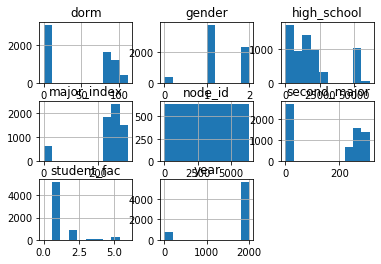

In [11]:
hist=tdata.hist(bins=10)

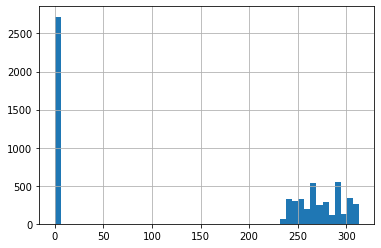

In [12]:
tdata['second_major'].hist(bins=50)

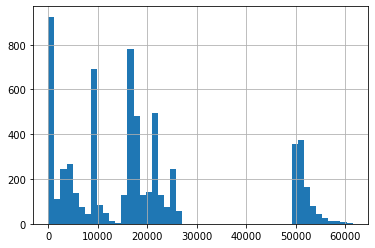

In [13]:
tdata['high_school'].hist(bins=50)

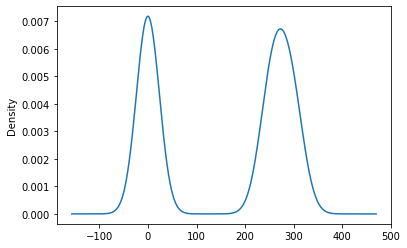

In [14]:
tdata['second_major'].plot(kind='kde')

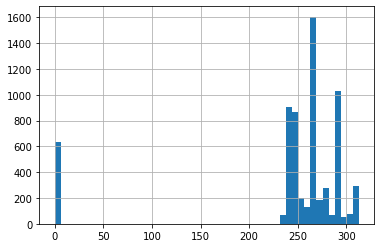

In [15]:
tdata['major_index'].hist(bins=50)

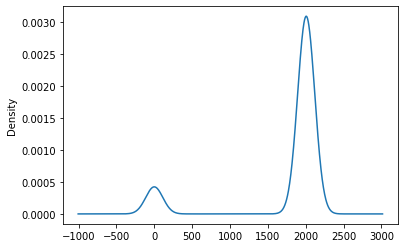

In [16]:
tdata['year'].plot(kind='kde')

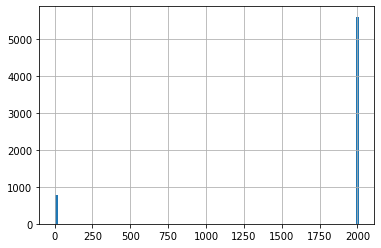

In [18]:
tdata['year'].hist(bins=100)

In [19]:
tdata.head()

,node_id,student_fac,gender,major_index,second_major,dorm,year,high_school
0,0,1,1,265,247,0,2008,9367
1,1,5,2,265,253,0,2006,23586
2,2,1,1,0,0,0,2009,50418
3,3,1,1,293,308,0,2007,9720
4,4,1,1,239,272,0,2005,22237


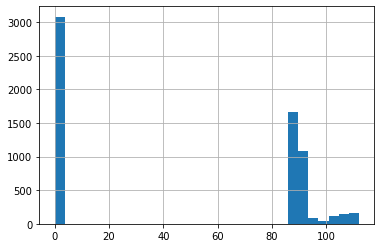

In [20]:
tdata['dorm'].hist(bins=30)

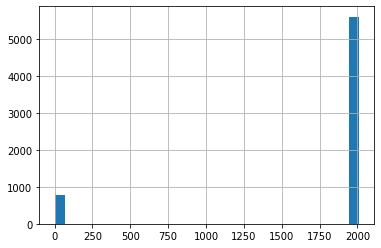

In [22]:
tdata['year'].hist(bins=30)

In [24]:
def normalize(x):
    def nf(f):
        temp = np.max(f)-np.min(f)
        nf = (f - np.min(f))/(temp)
        return nf
    return np.apply_along_axis(func1d=nf,axis=0,arr=x)

In [26]:
arr = np.array([[10,1],[20,2],[30,3],[10,2000]])
normalize(arr)

array([[0.00000000e+00, 0.00000000e+00],
       [5.00000000e-01, 5.00250125e-04],
       [1.00000000e+00, 1.00050025e-03],
       [0.00000000e+00, 1.00000000e+00]])

In [ ]:
np.mean([])